In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np 
import pickle

from sklearn.decomposition import PCA
from get_AM4_data_lw import  get_AM4_data_lw

In [2]:

out_filelist = [f'/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
inp_filelist = [f'/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]
inp_filelist, out_filelist

(['/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile1.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile2.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile3.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile4.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile5.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile6.nc'],
 ['/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile1.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile2.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile3.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile4.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile5.nc',
  '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile6.nc'])

In [3]:
# xr.open_dataset(inp_filelist[1])
# xr.open_dataset(out_filelist[1])
# xr.open_dataset(inp_filelist[1]).strat_size_drop[0,-1].fillna(0).min()

In [4]:
# diag speed
# %load_ext line_profiler


In [5]:
%%time 
# input_array_list, output_array_list = get_AM4_data_lw(out_filelist, inp_filelist, condition='af',)
input_array_list, output_array_list = \
    get_AM4_data_lw(out_filelist, inp_filelist, 
                  condition='af', month_sel = [1], 
                  day_sel = [15], return_coords = False)


Data files:
['/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile1.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile2.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile3.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile4.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile5.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.fluxes.tile6.nc'] ['/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile1.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile2.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile3.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile4.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile5.nc', '/stellar/scratch/gpfs/cw55/NNRTMC_data/AM4_v2/20000101.new_offline_input.tile6.nc']
Data selection:
    Month: [1] 


In [6]:
input_array_list.shape,output_array_list.shape,

((442368, 432), (442368, 36))

In [7]:
# try log scale
test_data = input_array_list[:1000,:3]
sigma = 1e-15
# sigma = 1e-25
test_data - np.exp(np.log(np.abs(test_data)+sigma))

array([[ 3.9062500e-02, -3.0517578e-05, -4.5776367e-05],
       [ 7.8125000e-03,  0.0000000e+00,  1.5258789e-05],
       [ 1.5625000e-02,  0.0000000e+00, -3.0517578e-05],
       ...,
       [-2.3437500e-02,  0.0000000e+00, -4.5776367e-05],
       [ 3.9062500e-02,  0.0000000e+00,  3.0517578e-05],
       [-4.6875000e-02,  0.0000000e+00,  4.5776367e-05]], dtype=float32)

# Checking data feature

In [8]:
def data_std_normalization(input_array, output_array, nomral_para = None):
    ###################################################### 
    if nomral_para == None:
        ## normalization based on data std
        input_scale     = input_array.std(axis=0)
        input_offset    = input_array.mean(axis=0)
        # check not varying input
        if np.any(np.isclose(input_scale,0)):
            print(f'Warning: {np.isclose(input_scale,0).sum()} input feature(s) is fixed!')
            input_scale     = np.where(np.isclose(input_scale,0), 1, input_scale)  
        input_scale     = 1/input_scale
        output_scale    = output_array.std(axis=0)
        output_offset   = output_array.mean(axis=0)
        # check not varying input
        if np.any(np.isclose(output_scale,0)):
            print(f'Warning: {np.isclose(output_scale,0).sum()} output feature(s) is fixed!')
            output_scale     = np.where(np.isclose(output_scale,0), 1, output_scale)  
        output_scale    = 1/output_scale
        nomral_para = {'input_scale'   : input_scale, 
                       'input_offset'  : input_offset,
                       'output_scale'  : output_scale,
                       'output_offset' : output_offset} 
    # do normalization
    input_array  = (input_array  - nomral_para['input_offset' ])*nomral_para['input_scale' ]
    output_array = (output_array - nomral_para['output_offset'])*nomral_para['output_scale']
    return nomral_para, input_array, output_array 
nomral_para, input_array_nor, output_array_nor = \
data_std_normalization(input_array_list, output_array_list)
# nomral_para, input_array_nor, output_array_nor = \
# data_std_normalization(np.log(np.abs(input_array_list)+1e-15), output_array_list)

# Plot scaled INPUT and OUTPUT

In [9]:
#randomly sample the columns
rd_id = np.random.randint(0,output_array_nor.shape[0],50000)

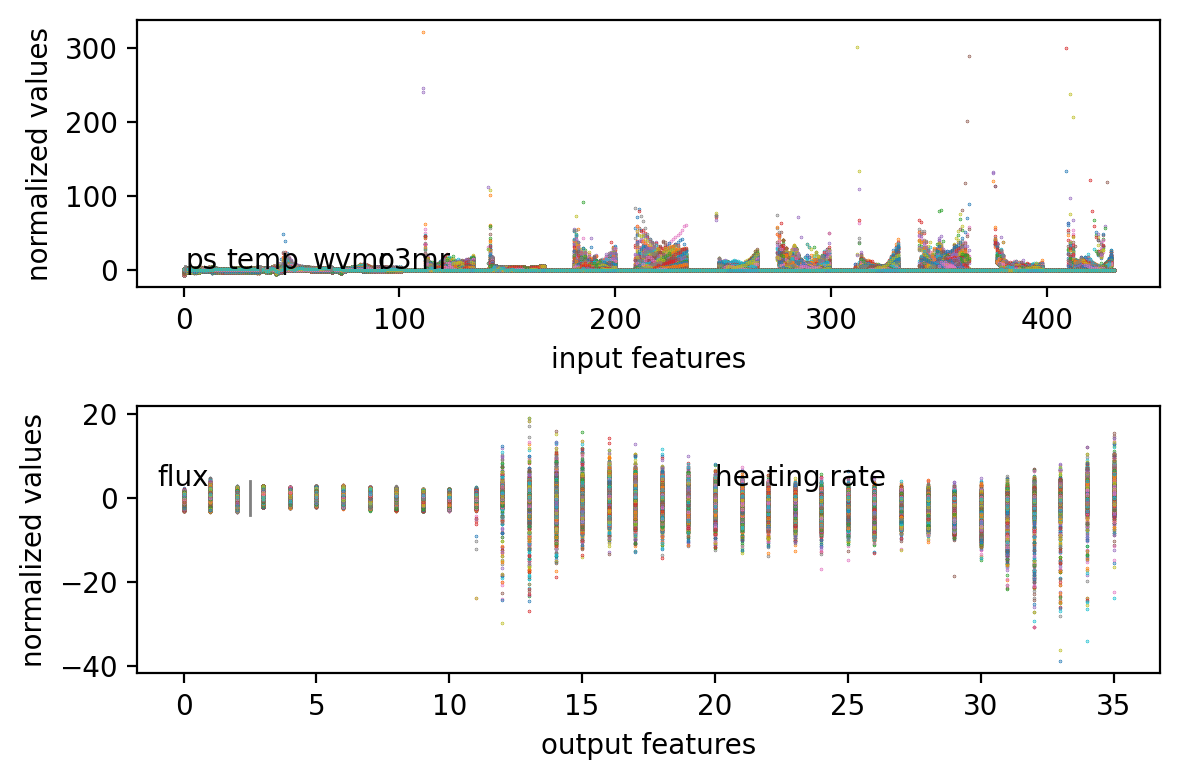

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,4),dpi=200) 

ax = axs[0]
ax.plot(input_array_nor[rd_id,:].T,'.',markersize=0.5)
ax.set_xlabel('input features')
ax.set_ylabel('normalized values')
ax.text(1,1.3,'ps')
ax.plot([0+  0.5, 0+   0.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 10,   1.3,'temp')
ax.plot([0+ 35.5, 0+  35.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 50,   1.3,'wvmr')
ax.plot([0+ 68.5, 0+  68.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 80,   1.3,'o3mr') 
ax = axs[1]
ax.plot(output_array_nor[rd_id,:].T,'.',markersize=0.5)
ax.set_xlabel('output features')
ax.set_ylabel('normalized values') 
ax.text(-1,3,'flux')
ax.plot([2.5,2.5],[-4,4],linewidth = 1,color='grey')
ax.text(20,3,'heating rate') 
fig.tight_layout()
fig.show()

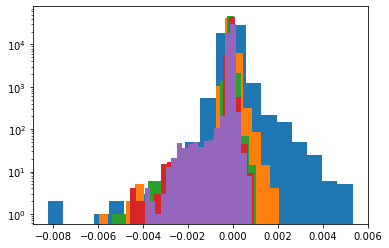

In [11]:
plt.hist(output_array_list[rd_id,-1]*5,bins=20)
plt.hist(output_array_list[rd_id,-2]*5,bins=20)
plt.hist(output_array_list[rd_id,-3]*5,bins=20)
plt.hist(output_array_list[rd_id,-4]*5,bins=20)
plt.hist(output_array_list[rd_id,-5]*5,bins=20)
plt.yscale('log')
# plt.xscale('symlog')
# plt.plot([-1,-1],[0,2000])

# PCA analysis 

In [12]:
#randomly sample the columns
rd_id_more = np.random.randint(0,input_array_nor.shape[0],100000)

In [13]:
X = np.concatenate((input_array_nor[rd_id_more,:],output_array_nor[rd_id_more,:]),axis=1)
# X = input_array_list
n_feature = input_array_nor.shape[1]+output_array_nor.shape[1]
n_components = 40
pca = PCA(n_components=n_components)
pca.fit(X)
n_pc = pca.components_
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.18062352 0.09573291 0.06924451 0.04898792 0.04014557 0.02897053
 0.02494626 0.02102188 0.01963144 0.01858357 0.01738579 0.01491511
 0.01431776 0.01242729 0.01122675 0.01090968 0.01005918 0.00930051
 0.00887892 0.00864409 0.0080248  0.00757192 0.00728883 0.00722757
 0.00698607 0.00683395 0.00670582 0.00631716 0.00598351 0.00578923
 0.0056745  0.00545434 0.00537374 0.00525745 0.00502208 0.00485471
 0.00464933 0.00449225 0.00446072 0.0044136 ]


0.7843347974277556

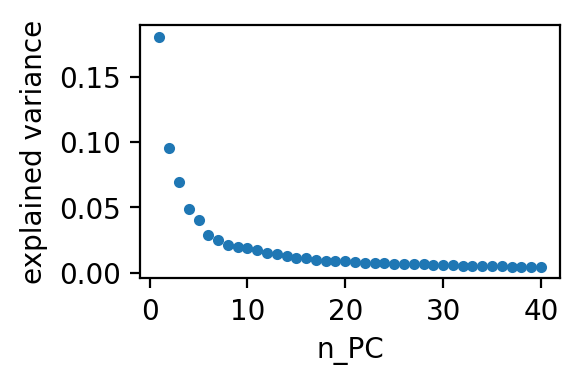

In [14]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,2),dpi=200) 
ax = axs
ax.plot(np.arange(1,n_components+1),pca.explained_variance_ratio_,'.')
ax.set_xlabel('n_PC')
ax.set_ylabel('explained variance')
fig.tight_layout()
fig.show()

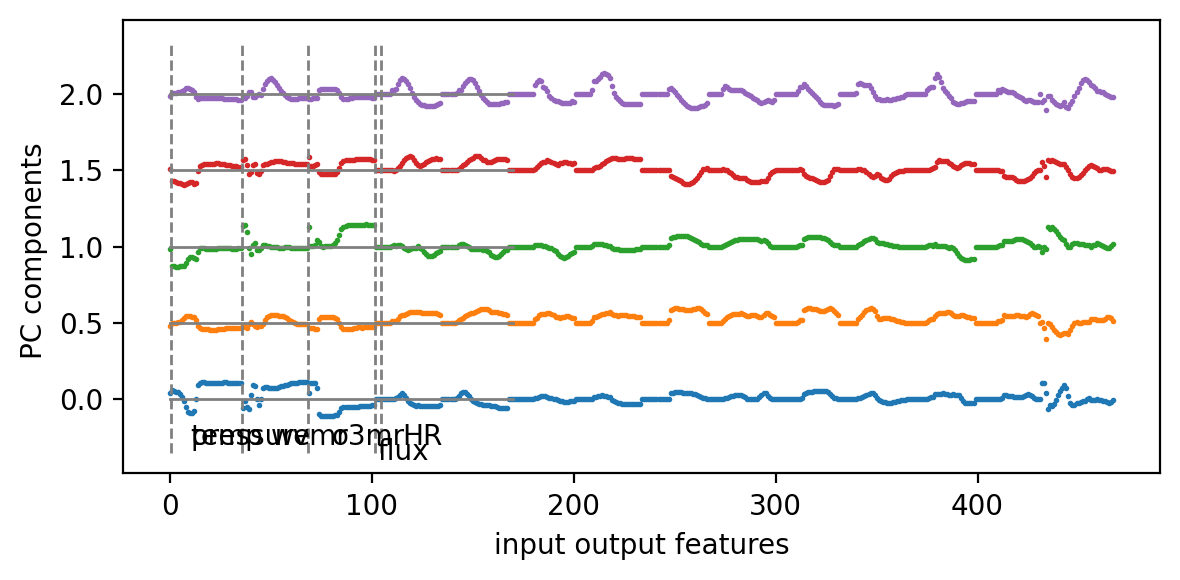

In [15]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,3),dpi=200) 
ax = axs 
for i in range(5):
    ax.plot(np.arange(n_feature),n_pc[i]+0.5*i,'.',markersize=2) 
    ax.plot([  0,  33+137], [0.5*i, 0.5*i],c='grey',linewidth=1) 
ax.text( 10      ,  - 0.3, 'pressure')
ax.plot([0+  0.5, 0+   0.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 10,    - 0.3, 'temp')
ax.plot([0+ 35.5, 0+  35.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 50,    - 0.3, 'wvmr')
ax.plot([0+ 68.5, 0+  68.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 80,    - 0.3, 'o3mr')
ax.plot([0+101.5, 0+ 101.5],[-0.35,2.35], '--', linewidth = 1,color='grey') 
ax.text( 0+ 103,   - 0.4, 'flux')
ax.plot([0+ 104.5,0+ 104.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 115,   - 0.3, 'HR')
ax.set_ylabel('PC components ')
ax.set_xlabel('input output features')
fig.tight_layout()
fig.show()

# Energy conservation

In [16]:
hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values[None,:]
B_k = hybrid_p_sigma_para.bk.values[None,:]
def return_dP_AM4_plev( ps, Ak, Bk): 
    """
    ps: Pa

    return: dP of levels
    """ 
    p_int = Ak + Bk*ps 
    dp = np.diff(p_int)
    return dp

Text(0, 0.5, 'frequency')

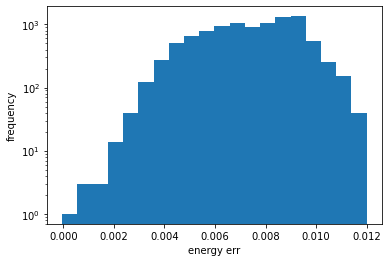

In [17]:
F_toa_up = output_array_list[:,2]
F_sfc_up = output_array_list[:,1]
F_sfc_do = output_array_list[:,0]
F_net = F_sfc_up - F_sfc_do - F_toa_up

C_p = 1004       # J/kg/K 
# g   = 9.8004     # m/s^2 
g   = 9.8        # m/s^2 

rd_id_e = np.random.randint(0,input_array_nor.shape[0],10000) # sample data
HR =  output_array_list[rd_id_e,3:]  
ps = input_array_list[rd_id_e,0,None] 
dP = return_dP_AM4_plev(ps,A_k,B_k)
sum_Cphr_gdp = C_p/g * (HR*dP).sum(axis=-1) 

E_err = F_net[rd_id_e]-sum_Cphr_gdp

plt.hist(E_err, bins=20)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy err')
plt.ylabel('frequency')

In [18]:
((E_err**2).mean())**0.5

0.007646818768015042

Text(0, 0.5, 'frequency')

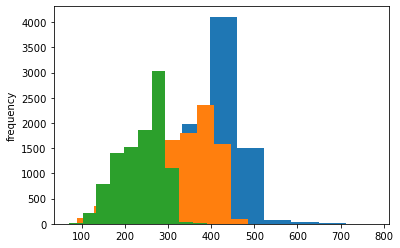

In [19]:

plt.hist(F_sfc_up[rd_id_e])
plt.hist(F_sfc_do[rd_id_e])
plt.hist(F_toa_up[rd_id_e])
# plt.xlabel('energy err') 
plt.ylabel('frequency')

(array([2.410e+02, 9.200e+02, 2.705e+03, 1.959e+03, 1.945e+03, 1.416e+03,
        6.700e+02, 1.300e+02, 1.200e+01, 2.000e+00]),
 array([-289.78537  , -260.25812  , -230.73088  , -201.20364  ,
        -171.67639  , -142.14915  , -112.62191  ,  -83.094666 ,
         -53.567425 ,  -24.040182 ,    5.4870605], dtype=float32),
 <BarContainer object of 10 artists>)

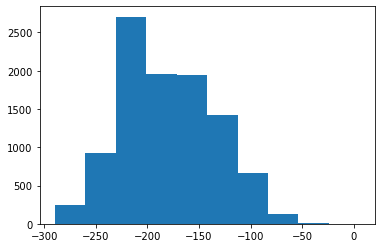

In [20]:
plt.hist(F_net[rd_id_e])

# Test rlus

In [21]:
inp_ds =  xr.open_dataset(inp_filelist[1])
out_ds =  xr.open_dataset(out_filelist[1])

In [22]:
F_sfc_up = out_ds.rlu.isel(phalf=-1).stack(txy=("time","grid_yt", "grid_xt")).values
Ts = inp_ds.surface_temperature.stack(txy=("time","grid_yt", "grid_xt")).values

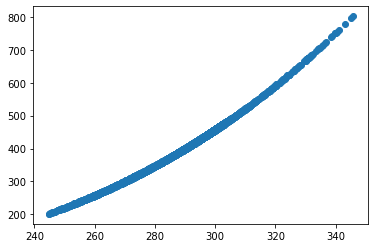

In [23]:
rd_id_e = np.random.randint(0,output_array_list.shape[0],10000) # sample data
plt.scatter(Ts[rd_id_e],F_sfc_up[rd_id_e]) 

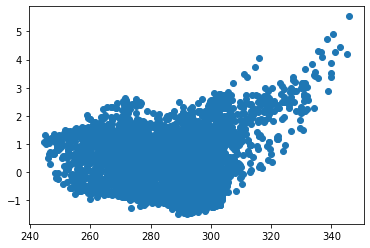

In [24]:
constant = 5.6521387e-08
plt.scatter(Ts[rd_id_e],constant*Ts[rd_id_e]**4-F_sfc_up[rd_id_e]) 

In [25]:
(F_sfc_up[rd_id_e]/Ts[rd_id_e]**4).mean()

5.651128e-08

In [26]:
dt = (inp_ds.surface_temperature.stack(txy=("time","grid_yt", "grid_xt")).values\
-inp_ds.level_temperature.isel(phalf=-1).stack(txy=("time","grid_yt", "grid_xt")).values)

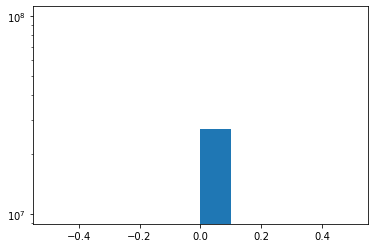

In [27]:
plt.hist(dt)
plt.yscale('log')